# 透過機器學習去預測壞帳機率
#### 我們會先對資料進行預處理(清理資料+產生dummy variables+標準化)
### 匯入需要用到的函式庫

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
from azureml.core import Workspace, Experiment, Run
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

/anaconda/envs/py36/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (urllib3 1.25.2 (/data/anaconda/envs/py36/lib/python3.6/site-packages), Requirement.parse('urllib3<1.25,>=1.21.1'), {'requests'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core:PipelineRun._from_dto with exception (urllib3 1.25.2 (/data/anaconda/envs/py36/lib/python3.6/site-packages), Requirement.parse('urllib3<1.25,>=1.21.1'), {'requests'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.ReusedStepRun = azureml.pipeline.core:StepRun._from_reused_dto with exception (urllib3 1.25.2 (/data/anaconda/envs/py36/lib/python3.6/site-p

### 跟Microsoft取得驗證

In [2]:
ws = Workspace.from_config()
experiment = Experiment(workspace = ws, name = "ML")

### 讀取csv檔

In [3]:
df = pd.read_csv("Default.csv", low_memory=False)
df = df.dropna(axis=0)

In [4]:
df.head(3)

,addr_state,annual_inc,application_type,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,...,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,zip_code
0,PA,55000.0,Individual,5.91,Aug-2003,10+ years,leadman,679.0,675.0,C,...,0.0,debt_consolidation,2765.0,29.7,C4,36 months,Debt consolidation,13.0,Not Verified,190xx
1,SD,65000.0,Individual,16.06,Dec-1999,10+ years,Engineer,719.0,715.0,C,...,0.0,small_business,21470.0,19.2,C1,36 months,Business,38.0,Not Verified,577xx
3,NJ,110000.0,Individual,17.06,Sep-2008,10+ years,Information Systems Officer,789.0,785.0,C,...,0.0,debt_consolidation,7802.0,11.6,C5,60 months,Debt consolidation,17.0,Source Verified,076xx


### 刪除無用的資料

In [5]:
dropList = ["earliest_cr_line", "zip_code", "title", "id", "emp_title", "sub_grade", "issue_d", "fico_range_low"]
for i in dropList:
    df = df.drop([i], axis = 1)

### 處理資料轉換資料類型

In [6]:
def to_int(x):
    if x[2] == "+":
        return 10
    elif x[0] == "<":
        return 0
    else:
        return int(x[0])
    
def loan(x):
    if x == "Fully Paid":
        return 0
    elif x == "Charged Off" or x == "Late (31-120 days)" or x == "Late (16-30 days)" or x == "Default":
        return 1
    elif x == "In Grace Period" or x == "Current":
        return 2
    
def source(x):
    if x == "Source Verified" or "Verified":
        return 1
    else:
        return 0
    

mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
df['grade'] = df['grade'].map(mapping)
df["emp_length"] = df["emp_length"].apply(lambda x: to_int(x))
df["loan_status"] = df["loan_status"].apply(lambda x: loan(x))
df["verification_status"] = df["verification_status"].apply(lambda x: source(x))

### 根據loan status去劃分，把現在還在進行的貸款放在其他變數儲存

In [7]:
is_valid = df["loan_status"] != 2
isnot_valid = df["loan_status"] == 2
current = df[isnot_valid]
df = df[is_valid]

### 產生dummy variables

In [8]:
new_df = pd.get_dummies(df, drop_first=True)
new_df.head()

,annual_inc,dti,emp_length,fico_range_high,grade,installment,int_rate,loan_amnt,loan_status,mort_acc,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_60 months
0,55000.0,5.91,10,679.0,3,123.03,13.99,3600.0,0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,65000.0,16.06,10,719.0,3,820.28,11.99,24700.0,0,4.0,...,0,0,0,0,0,0,1,0,0,0
4,104433.0,25.37,3,699.0,6,289.91,22.45,10400.0,0,6.0,...,0,1,0,0,0,0,0,0,0,1
5,34000.0,10.20,4,694.0,3,405.18,13.44,11950.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,180000.0,14.67,10,684.0,2,637.58,9.17,20000.0,0,4.0,...,0,0,0,0,0,0,0,0,0,0


### 調整一下column順序，方便後續處理

In [9]:
cols = ['loan_status', 'annual_inc', 'dti', 'emp_length', 'fico_range_high', 'grade',
       'installment', 'int_rate', 'loan_amnt', 'mort_acc',
       'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal',
       'revol_util', 'total_acc', 'verification_status', 'addr_state_AL',
       'addr_state_AR', 'addr_state_AZ', 'addr_state_CA', 'addr_state_CO',
       'addr_state_CT', 'addr_state_DC', 'addr_state_DE', 'addr_state_FL',
       'addr_state_GA', 'addr_state_HI', 'addr_state_IA', 'addr_state_ID',
       'addr_state_IL', 'addr_state_IN', 'addr_state_KS', 'addr_state_KY',
       'addr_state_LA', 'addr_state_MA', 'addr_state_MD', 'addr_state_ME',
       'addr_state_MI', 'addr_state_MN', 'addr_state_MO', 'addr_state_MS',
       'addr_state_MT', 'addr_state_NC', 'addr_state_ND', 'addr_state_NE',
       'addr_state_NH', 'addr_state_NJ', 'addr_state_NM', 'addr_state_NV',
       'addr_state_NY', 'addr_state_OH', 'addr_state_OK', 'addr_state_OR',
       'addr_state_PA', 'addr_state_RI', 'addr_state_SC', 'addr_state_SD',
       'addr_state_TN', 'addr_state_TX', 'addr_state_UT', 'addr_state_VA',
       'addr_state_VT', 'addr_state_WA', 'addr_state_WI', 'addr_state_WV',
       'addr_state_WY', 'application_type_Joint App',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'initial_list_status_w',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'term_60 months']
new_df = new_df.reindex(columns= cols)

In [10]:
new_df.head()

,loan_status,annual_inc,dti,emp_length,fico_range_high,grade,installment,int_rate,loan_amnt,mort_acc,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_60 months
0,0,55000.0,5.91,10,679.0,3,123.03,13.99,3600.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0,65000.0,16.06,10,719.0,3,820.28,11.99,24700.0,4.0,...,0,0,0,0,0,0,1,0,0,0
4,0,104433.0,25.37,3,699.0,6,289.91,22.45,10400.0,6.0,...,0,1,0,0,0,0,0,0,0,1
5,0,34000.0,10.20,4,694.0,3,405.18,13.44,11950.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,0,180000.0,14.67,10,684.0,2,637.58,9.17,20000.0,4.0,...,0,0,0,0,0,0,0,0,0,0


### 分割測試和訓練資料，並進行標準化

In [11]:
x, y = new_df.iloc[:, 1:].values, new_df.iloc[:, 0].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3, stratify=y)

In [12]:
stdsc = StandardScaler()
x_train_std = stdsc.fit_transform(x_train)
x_test_std = stdsc.fit_transform(x_test)

### Logistic Model

In [13]:
lr = LogisticRegression(penalty="l2", C=1.0)
lr.fit(x_train_std, y_train)

/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
y_test_predicted = lr.predict(x_test_std)
y_score = lr.predict_proba(x_test_std)[:,1]
print(f"Logistic accuracy score:{metrics.accuracy_score(y_test, y_test_predicted):.2f}")
print(f"Logistic precision score:{metrics.precision_score(y_test, y_test_predicted):.2f}")
print(f"Logistic recall score:{metrics.recall_score(y_test, y_test_predicted):.2f}")
print(f"Logistic ROC-AUC score:{metrics.roc_auc_score(y_test, y_test_predicted):.2f}")

Logistic accuracy score:0.79
Logistic precision score:0.53
Logistic recall score:0.11
Logistic ROC-AUC score:0.54


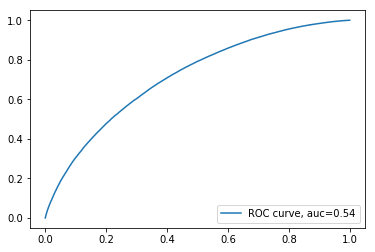

In [15]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
auc = metrics.roc_auc_score(y_test, y_test_predicted)
plt.plot(fpr, tpr, label=f"ROC curve, auc={auc:.2f}")
plt.legend(loc=4)
plt.show()

In [21]:
for k, v in zip(cols[1:], lr.coef_[0]):
    print(k, v)

annual_inc -0.04091613938846942
dti 0.16347463620615324
emp_length -0.01394099996012973
fico_range_high -0.2291243167275028
grade 0.18809933915622362
installment 0.09147243268359864
int_rate 0.22129311956924083
loan_amnt 0.04944092721061639
mort_acc -0.11169192516085935
open_acc 0.11941641170948912
pub_rec 0.01513459591956979
pub_rec_bankruptcies -0.0006851673161721132
revol_bal -0.07519623826113289
revol_util -0.04692500638247203
total_acc -0.11725961037959033
verification_status 0.0
addr_state_AL 0.020375877624013997
addr_state_AR 0.022995709682082283
addr_state_AZ -0.0027041623959691455
addr_state_CA -0.02189691976424381
addr_state_CO -0.0484671622297022
addr_state_CT -0.018282412140915208
addr_state_DC -0.02544275867223097
addr_state_DE -0.000680113473578078
addr_state_FL 0.012455270111041706
addr_state_GA -0.02105720905541522
addr_state_HI -0.014354210831438586
addr_state_IA 0.008114612746626714
addr_state_ID -0.010706458686270367
addr_state_IL -0.0199387013847703
addr_state_IN 0.

### Random Forest

In [16]:
forest = RandomForestClassifier(criterion="gini", n_estimators=300, random_state=5, n_jobs=-1)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [18]:
y_test_predicted = forest.predict(x_test)
y_score = forest.predict_proba(x_test)[:,1]
print(f"Random Forest accuracy score:{metrics.accuracy_score(y_test, y_test_predicted):.2f}")
print(f"Random Forest precision score:{metrics.precision_score(y_test, y_test_predicted):.2f}")
print(f"Random Forest recall score:{metrics.recall_score(y_test, y_test_predicted):.2f}")

Random Forest accuracy score:0.79
Random Forest precision score:0.57
Random Forest recall score:0.09
